### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

План занятия:

1. задача сегментации аудитории по интересам - для чего
2. тематическое моделирование - получаем эмбединги текстов
3. решаем downstream-задачу (профилирование аудитории новостного портала)

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока

#### Задача сегментации (неформальное определение)

Разбиваем пользователей на группы, чем-то отличающиеся друг от друга

Если же более формально, то:

Сегментация клиентской базы — это способ повышения эффективности работы с пользователями путем их распределения по отдельным группам, или сегментам, в соответствии с их запросами и/или потребностями.

Сегментация может быть очень разной:

### Переходим к практике

Три ячейки ниже делаем в Google Colaboratory

- установим razdel
- установим pymorphy2

In [ ]:
!pip install razdel

In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.8 MB/s 
     |████████████████████████████████| 8.2 MB 14.3 MB/s 


In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 8.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7 MB 1.4 MB/s 
     |████████████████████████████████| 11.3 MB 47.6 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=fbf136eb16e3b2141d595444a2bcfd85dff866c80e60d855d0a70d07cd7c92e4
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take int

In [ ]:
!pip uninstall numpy
!pip uninstall pandas

!pip install --user numpy
!pip install --user  pandas

Found existing installation: numpy 1.21.4
Uninstalling numpy-1.21.4:


Делаем доступ к Googl Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Наши новости

In [3]:
import pandas as pd

In [4]:
path = '/gdrive/MyDrive/app/'

In [5]:
news = pd.read_csv(path+"articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [6]:
news.shape

(27000, 2)

Загрузим пользователей и списки последних прочитанных новостей

In [7]:
users = pd.read_csv(path+"users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [8]:
#from gensim.test.utils import common_texts
# https://webdevblog.ru/gensim-rukovodstvo-dlya-nachinajushhih/
from gensim.corpora.dictionary import Dictionary

In [9]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer(  )

In [12]:
len(stopword_ru)

151

In [13]:
with open(path+'stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [14]:
stopword_ru[0]

'и'

In [15]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub("n", ' ', text)

    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    #print(tokens)
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
                #print(temp_cach)
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
                #print(w,' : ',temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    #print(words_lem_without_stopwords)
    return words_lem_without_stopwords

In [16]:
list(tokenize(news.iloc[0,1][:100],   ))

[Substring(0, 11, 'Заместитель'),
 Substring(12, 24, 'председателя'),
 Substring(24, 25, 'n'),
 Substring(25, 38, 'правительства'),
 Substring(39, 41, 'РФ'),
 Substring(41, 42, 'n'),
 Substring(42, 48, 'Сергей'),
 Substring(48, 49, 'n'),
 Substring(49, 55, 'Иванов'),
 Substring(55, 56, 'n'),
 Substring(56, 62, 'избран'),
 Substring(63, 76, 'председателем'),
 Substring(77, 83, 'совета'),
 Substring(83, 84, 'n'),
 Substring(84, 87, 'ПБК'),
 Substring(88, 92, 'ЦСКА'),
 Substring(92, 93, 'n'),
 Substring(93, 94, '.'),
 Substring(95, 98, 'Как'),
 Substring(99, 100, 'с')]

In [17]:
norm_text = news.iloc[:2,1].apply(lambda x: clean_text(x), 1)
norm_text

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [18]:
lemmatization(norm_text[0])

['заместитель',
 'председатель',
 'правительство',
 'рф',
 'сергей',
 'иванов',
 'избрать',
 'председатель',
 'совет',
 'пбк',
 'цска',
 'прессслужба',
 'армеец',
 'решение',
 'единогласно',
 'принять',
 'первый',
 'заседание',
 'совет',
 'клуб',
 'основной',
 'функция',
 'орган',
 'обсуждение',
 'текущий',
 'состояние',
 'планирование',
 'утверждение',
 'стратегия',
 'развитие',
 'клуб',
 'близкий',
 'перспектива',
 'состав',
 'совет',
 'войти',
 'георгий',
 'полтавченко',
 'полномочный',
 'центральный',
 'федеральный',
 'округ',
 'алексей',
 'седов',
 'генералполковник',
 'начальник',
 'служба',
 'защита',
 'конституционный',
 'строй',
 'борьба',
 'терроризм',
 'фсб',
 'рф',
 'александр',
 'новак',
 'заместитель',
 'министр',
 'финансы',
 'рф',
 'вячеслав',
 'полтавец',
 'заместитель',
 'генеральный',
 'директор',
 'руководитель',
 'блок',
 'взаимодействие',
 'орган',
 'власть',
 'социальный',
 'корпоративный',
 'политика',
 'гмк',
 'норильский',
 'никель',
 'леонид',
 'исакович',
 '

In [19]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 25.2 s, sys: 1.73 s, total: 27 s
Wall time: 27 s


In [20]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 19s, sys: 722 ms, total: 4min 20s
Wall time: 4min 20s


А теперь в 3 строчки обучим нашу модель

In [21]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [22]:
common_dictionary[4]

'банк'

In [23]:
common_dictionary.id2token

{0: 'александр',
 1: 'алексей',
 2: 'андрей',
 3: 'армеец',
 4: 'банк',
 5: 'баскетбол',
 6: 'близкий',
 7: 'блок',
 8: 'борьба',
 9: 'ватутин',
 10: 'взаимодействие',
 11: 'власть',
 12: 'войти',
 13: 'вячеслав',
 14: 'генералполковник',
 15: 'генеральный',
 16: 'георгий',
 17: 'гмк',
 18: 'директор',
 19: 'европа',
 20: 'единогласно',
 21: 'заместитель',
 22: 'заседание',
 23: 'защита',
 24: 'иванов',
 25: 'избрать',
 26: 'исакович',
 27: 'клиентский',
 28: 'клуб',
 29: 'конституционный',
 30: 'корпоративный',
 31: 'леонид',
 32: 'лопат',
 33: 'министр',
 34: 'мир',
 35: 'начальник',
 36: 'никель',
 37: 'новак',
 38: 'норильский',
 39: 'оао',
 40: 'обсуждение',
 41: 'округ',
 42: 'ольга',
 43: 'ооо',
 44: 'орган',
 45: 'основной',
 46: 'пбк',
 47: 'первый',
 48: 'перспектива',
 49: 'планирование',
 50: 'плешаков',
 51: 'политика',
 52: 'полномочный',
 53: 'полтавец',
 54: 'полтавченко',
 55: 'правительство',
 56: 'правление',
 57: 'председатель',
 58: 'прессслужба',
 59: 'принять',
 

Делаем BoW по списку слов

In [24]:
common_dictionary.doc2bow(['баскетбол' ,'баскетбол' ,'баскетбол' ,'наше', 'все'], allow_update=True)

[(5, 3), (135645, 1), (135646, 1)]

In [25]:
common_corpus[0][0]

(0, 2)

In [26]:
len(texts[0])

113

Все просто - это словарь наших слов

Запускаем обучение

In [27]:
N_topic = 20 # число тем - гиперпараметр

In [28]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

CPU times: user 48.6 s, sys: 23.5 s, total: 1min 12s
Wall time: 45.8 s


In [29]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [30]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(1, 0.098769724),
 (2, 0.20876849),
 (5, 0.24007873),
 (10, 0.33251977),
 (14, 0.10111326)]

In [31]:
x=lda.show_topics(num_topics=N_topic, num_words=15,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: женщина жизнь день учёный мозг мужчина дом клетка ребёнок место университет житель всё тыс час
topic_1: фестиваль сайт мир мероприятие история состояться первый небо известный ature лунный археолог посвятить гость живой
topic_2: научный исследование всё большой военный спутник первый журнал россия уровень пенсия высокий новый риск двигатель
topic_3: всё млрд исследователь россия очень путин экономический вопрос государство проблема эксперт новый большой уровень пока
topic_4: сша американский опубликовать исследование смерть санкция взрыв район учёный российский россия пострадать расследование препарат помощь
topic_5: животное млн учёный станция тыс птица писать университет вицепремьер предмет наблюдаться снег стоимость составить лётчик
topic_6: наука учёный газпром министерство ран ген исследование россия канал ленин академия огонь первый вуз министр
topic_7: экономика банк эксперимент планета доллар космос восток температура первый расход инвестор строительство вирус новый ро

Очень неплохо - большинство тем вполне можно описать о чем они


построим темы 

In [32]:
news['title'].iloc[5]

['ио',
 'главное',
 'тренер',
 'вячеслав',
 'буцай',
 'прокомментировать',
 'победа',
 'югра',
 'матч',
 'регулярный',
 'чемпионат',
 'кхл',
 'прежде',
 'хотеть',
 'поблагодарить',
 'ребята',
 'команда',
 'передавать',
 'официальный',
 'сайт',
 'югра',
 'игра',
 'начинаться',
 'очень',
 'удачно',
 'пропустить',
 'гол',
 'первый',
 'смена',
 'долго',
 'входить',
 'игра',
 'связать',
 'дневный',
 'матч',
 'непривычный',
 'плюс',
 'третий',
 'матч',
 'сибирь',
 'гдеть',
 'ребята',
 'чувствовать',
 'скажем',
 'сонный',
 'второй',
 'третий',
 'период',
 'показать',
 'разбежаться',
 'играть',
 'правильно',
 'появиться',
 'момент',
 'дотерпеть',
 'заслуженно',
 'победить']

In [33]:
lda[common_dictionary.doc2bow(news['title'].iloc[10])]

[(1, 0.3506704), (2, 0.21596414), (6, 0.33188793), (10, 0.076477535)]

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [34]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [35]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050587,0.369957,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.572001,0.000000,0.0
1,4896,0.213291,0.246317,0.000000,0.000000,0.392182,0.000000,0.094430,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.035488,0.000000,0.0,0.0,0.000000,0.000000,0.0
2,4897,0.000000,0.098620,0.208806,0.000000,0.000000,0.240128,0.000000,0.000000,0.0,0.000000,0.332664,0.0,0.0,0.000000,0.101031,0.0,0.0,0.000000,0.000000,0.0
3,4898,0.000000,0.000000,0.123041,0.842491,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.024102,0.0
4,4899,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.067913,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.907763,0.000000,0.0


In [ ]:
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.014615,0.0,0.0,0.000000,0.115957,0.000000,0.0,0.679062,0.000000,0.0,0.183348,0.000000
1,4896,0.000000,0.0,0.000000,0.000000,0.0,0.22552,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.752529,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2,4897,0.000000,0.0,0.000000,0.039912,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.550553,0.347962,0.0,0.000000,0.041573,0.0,0.000000,0.000000
3,4898,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.162448,0.089447,0.0,0.0,0.016871,0.278302,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.443785
4,4899,0.326667,0.0,0.526583,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.123777,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [39]:
users.head(10)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"
5,u106662,"[323868, 323426, 324267, 322426, 324104, 1550]"
6,u105949,"[293138, 294471, 295012, 294736, 293949, 3544]"
7,u102457,"[6928, 5009, 6940, 7629, 7644, 512736]"
8,u104124,"[322838, 324699, 322991, 322120, 324327, 472331]"
9,u101386,"[7827, 6427, 7394, 7151, 6335, 487254]"


In [40]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))

In [41]:
doc_dict[293622]

array([0.29020014, 0.27474919, 0.0312889 , 0.        , 0.13299219,
       0.02308879, 0.        , 0.        , 0.14079957, 0.        ,
       0.02309956, 0.        , 0.        , 0.        , 0.        ,
       0.07739872, 0.        , 0.        , 0.        , 0.        ])

In [83]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = np.max(user_vector, 0)  # можно не средний
    return user_vector1 #,user_vector

def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = np.median(user_vector, 0)  # можно не средний
    return user_vector1 #,user_vector
  
def get_user_embedding_mean(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = np.mean(user_vector, 0)  # можно не средний
    return user_vector1 #,user_vector

In [84]:
user_articles_list = users['articles'].iloc[33]

In [85]:
vv_max = get_user_embedding_max(user_articles_list)
vv_median = get_user_embedding_median(user_articles_list)
vv_mean = get_user_embedding_median(user_articles_list)

print(vv_max)
print(vv_median)
print(vv_mean)

[0.35756347 0.         0.33504522 0.12669575 0.35179156 0.
 0.3562381  0.         0.23204193 0.         0.18020737 0.5789634
 0.02883003 0.02089464 0.20475368 0.0387769  0.13339376 0.4242591
 0.3198401  0.14349261]
[0.         0.         0.         0.01133765 0.15073859 0.
 0.         0.         0.05093446 0.         0.         0.
 0.         0.         0.         0.         0.         0.11543502
 0.08932153 0.        ]
[0.         0.         0.         0.01133765 0.15073859 0.
 0.         0.         0.05093446 0.         0.         0.
 0.         0.         0.         0.         0.         0.11543502
 0.08932153 0.        ]


In [86]:
import matplotlib.pyplot as plt

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [ ]:
#users['articles'].iloc[33]

In [ ]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [93]:
user_embeddings = []
for i, f in enumerate([get_user_embedding_max, get_user_embedding_mean, get_user_embedding_median]):
  user_embeddings += [pd.DataFrame([i for i in users['articles'].apply(lambda x: f(x), 1)])]
  user_embeddings[i].columns = ['topic_{}'.format(i) for i in range(N_topic)]
  user_embeddings[i]['uid'] = users['uid'].values
  user_embeddings[i] = user_embeddings[i][['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
  user_embeddings[i].head(3)
user_embeddings

[          uid   topic_0   topic_1  ...  topic_17  topic_18  topic_19
 0     u105138  0.290200  0.274749  ...  0.305878  0.467989  0.000000
 1     u108690  0.253942  0.038079  ...  0.094047  0.369583  0.036202
 2     u108339  0.322660  0.000000  ...  0.230952  0.324418  0.060211
 3     u101138  0.050108  0.170436  ...  0.039639  0.018695  0.015220
 4     u108248  0.325908  0.062484  ...  0.403213  0.116186  0.054960
 ...       ...       ...       ...  ...       ...       ...       ...
 7995  u107463  0.103770  0.323475  ...  0.358090  0.242656  0.027943
 7996  u101241  0.055381  0.380588  ...  0.356514  0.482344  0.000000
 7997  u106486  0.261763  0.069499  ...  0.194352  0.193713  0.025063
 7998  u102220  0.055299  0.585061  ...  0.331568  0.150125  0.110946
 7999  u105118  0.442113  0.557035  ...  0.155655  0.308856  0.000000
 
 [8000 rows x 21 columns],
           uid   topic_0   topic_1  ...  topic_17  topic_18  topic_19
 0     u105138  0.144230  0.109738  ...  0.098285  0.128880  

Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [48]:
target = pd.read_csv(path+"users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [107]:
X = []
for user in user_embeddings:
  X += [pd.merge(user, target, 'left')]
X

[          uid   topic_0   topic_1  ...  topic_18  topic_19  churn
 0     u105138  0.290200  0.274749  ...  0.467989  0.000000      0
 1     u108690  0.253942  0.038079  ...  0.369583  0.036202      1
 2     u108339  0.322660  0.000000  ...  0.324418  0.060211      1
 3     u101138  0.050108  0.170436  ...  0.018695  0.015220      0
 4     u108248  0.325908  0.062484  ...  0.116186  0.054960      1
 ...       ...       ...       ...  ...       ...       ...    ...
 7995  u107463  0.103770  0.323475  ...  0.242656  0.027943      0
 7996  u101241  0.055381  0.380588  ...  0.482344  0.000000      0
 7997  u106486  0.261763  0.069499  ...  0.193713  0.025063      0
 7998  u102220  0.055299  0.585061  ...  0.150125  0.110946      0
 7999  u105118  0.442113  0.557035  ...  0.308856  0.000000      0
 
 [8000 rows x 22 columns],
           uid   topic_0   topic_1  ...  topic_18  topic_19  churn
 0     u105138  0.144230  0.109738  ...  0.128880  0.000000      0
 1     u108690  0.112814  0.01128

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [126]:
#разделим данные на train/test
learn = []
for x in X:
  X_train, X_test, y_train, y_test = train_test_split(x[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    x['churn'], random_state=0, test_size=0.25)
  learn += [[X_train, X_test, y_train, y_test]]

In [127]:
logreg = []
#обучим наш пайплайн
for i, l in enumerate(learn):
  logreg += [LogisticRegression(C=1.0)]
  logreg[i].fit(learn[i][0],learn[i][2])

In [128]:
#наши прогнозы для тестовой выборки
preds = []
for i, logr in enumerate(logreg):
  preds += [logr.predict_proba(learn[i][1])[:, 1]]
  preds[:10]

In [54]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

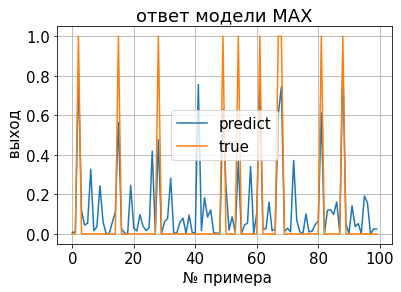

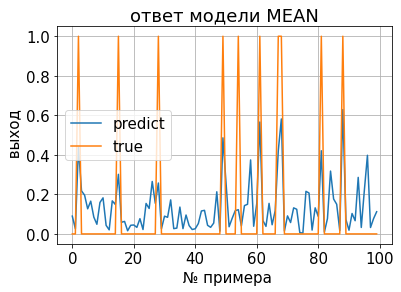

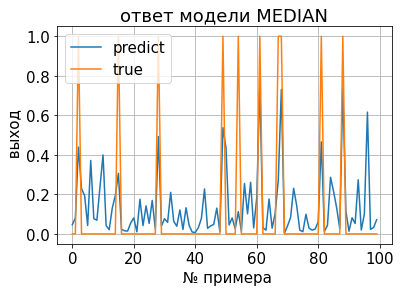

In [135]:
name = ['MAX', 'MEAN', 'MEDIAN']
for i, p in enumerate(preds):
  plt.plot( p[:100], label = 'predict')
  plt.plot(learn[i][3].values[:100], label = 'true')
  plt.title(f'ответ модели {name[i]}')
  plt.xlabel(' № примера')
  plt.ylabel(' выход')
  plt.legend()
  plt.grid('On')
  plt.show()

In [133]:
prc = []
for i, p in enumerate(preds):
  precision, recall, thresholds = precision_recall_curve(learn[i][3].values, p)
  prc += [[precision, recall, thresholds]]


In [144]:
prc_result = []

for i, value in enumerate(prc):
  n=-1
  fscore = (2 * value[0][:n] * value[1][:n]) / (value[0][:n] + value[1][:n])

  # locate the index of the largest f score
  ix = np.argmax(fscore)
  print(f'{name[i]} Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (value[2][ix], 
                                                                          fscore[ix],
                                                                          value[0][ix],
                                                                          value[1][ix]))
  prc_result += [[value[2][ix], fscore[ix], value[0][ix], value[1][ix]]]

MAX Best Threshold=0.362254, F-Score=0.722, Precision=0.729, Recall=0.714
MEAN Best Threshold=0.240197, F-Score=0.634, Precision=0.559, Recall=0.731
MEDIAN Best Threshold=0.256410, F-Score=0.704, Precision=0.651, Recall=0.767


In [171]:
total_result = []
for i, p in enumerate(preds):
  total_result += [prc_result[i] + [roc_auc_score(learn[i][3], p)]]
  
for i, value in enumerate(total_result):
  print(f'{name[i] + " " * (len(max(name))-len(name[i]))} Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc auc score=%.3f' % (value[0],value[1],value[2],value[3],value[4]))

MAX    Best Threshold=0.362254, F-Score=0.722, Precision=0.729, Recall=0.714, Roc auc score=0.957
MEAN   Best Threshold=0.240197, F-Score=0.634, Precision=0.559, Recall=0.731, Roc auc score=0.930
MEDIAN Best Threshold=0.256410, F-Score=0.704, Precision=0.651, Recall=0.767, Roc auc score=0.955


MEDIAN показывает лучшие результаты, так как снижается влияние "выбросов"

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk